In [37]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from enum import Enum
import scipy.stats
from omnetpp.scave import results, chart, utils

class StatType(Enum):
    SCALAR = "count"
    VECTOR = "vector"

DEBUG = False

mpl.rcParams['figure.dpi'] = 300

relPath = "../results/"
# ("readResponseReceivedTime", StatType.VECTOR), ("commandResponseReceivedTime", StatType.VECTOR),
cliMeasNames = [("readResponseReceivedTime", StatType.VECTOR), ("commandResponseReceivedTime", StatType.VECTOR), ("measureReceivedAmount", StatType.VECTOR), ("readSent", StatType.SCALAR), ("commandSent", StatType.SCALAR), ("readResponse", StatType.SCALAR), 
             ("commandResponse", StatType.SCALAR), ("readResponseTimeout", StatType.SCALAR), ("commandResponseTimeout", StatType.SCALAR)]
evilMeasNames = [("measureBlock", StatType.SCALAR), ("measureCompromised", StatType.SCALAR), ("readRequestBlock", StatType.SCALAR), ("readRequestCompromised", StatType.SCALAR), 
                 ("commandRequestBlock", StatType.SCALAR), ("commandRequestCompromised", StatType.SCALAR), ("readResponseBlock", StatType.SCALAR), ("readResponseCompromised", StatType.SCALAR),
                 ("commandResponseBlock", StatType.SCALAR), ("commandResponseCompromised", StatType.SCALAR)]
rep = 30
simTimeLimit = 120
numClients = 1
numServers = 2

fileNamesSca = []
fileNamesVec = []


simName = "MMS_MITM_Wireless"
for i in range(0,rep):
    fileNamesSca.append(relPath + simName + '-#' + i.__str__() + '.sca')
    fileNamesVec.append(relPath + simName + '-#' + i.__str__() + '.vec')
    

if DEBUG:
    print(fileNamesSca)
    print(fileNamesVec)


Function to create the statistics filter

In [38]:
def createFilter(measNames):
    filter = ""##"type =~ \"scalar\" AND ("
    for i in range(len(measNames)):
        if i != len(measNames)-1:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\" OR "
        else:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\""##)"
    return filter

In [39]:
dataSca = results.read_result_files(fileNamesSca, filter_expression=createFilter(cliMeasNames + evilMeasNames))
dataVec = results.read_result_files(fileNamesVec, filter_expression=createFilter(cliMeasNames + evilMeasNames))
vec = results.get_vectors(dataVec)
scl = results.get_scalars(dataSca)

if DEBUG:
    print(createFilter(cliMeasNames + evilMeasNames))
    scl.to_csv("./outSC.csv", mode="w", header=True)
    vec.to_csv("./outVC.csv", mode="w", header=True)

Plot client measures for each client aggregating all the repetitions 

In [40]:
def plotBoxWiskerSca(measNames, numClients, numServers, title = "", cli = "client"):
    fig, axes = plt.subplots(nrows=numClients, ncols=numServers)
    fig.set_figheight(17*numClients)
    fig.set_figwidth(22)
    
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            box = pd.DataFrame()
            for meas in measNames:
                strElem = ""
                if cli == "evilClient":
                    strElem = cli + ".app[" + str(j) + "]"
                else:
                    strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
                
                if meas[1] == StatType.SCALAR:
                    flt = scl[scl["name"].str.contains(meas[0] + ":" + meas[1].value)]
                    flt = flt[flt["module"].str.endswith(strElem)]
                    box[meas[0]] = flt["value"].reset_index(drop=True)
                 
            box = box.replace(np.nan, 0)
            outVec.append(box)
            if DEBUG:
                box.to_csv("./out.csv", mode="w", header=True)
            if numClients != 1: 
                box.boxplot(ax=axes[i][j], grid=False, rot=90)
                axes[i][j].set_title(title + " (" + strElem + ")", fontstyle='italic')
            else:
                box.boxplot(ax=axes[j], grid=False, rot=90)
                axes[j].set_title(title + " (" + strElem + ")", fontstyle='italic')
    return outVec

In [41]:
def plotBoxWiskerVec(numClients, numServers, title = "", cli = "client", vecMeasName = "measureReceivedAmount", numRanges = 0):
    fig, axes = plt.subplots(nrows=numClients, ncols=numServers)
    fig.set_figheight(12*numClients)
    fig.set_figwidth(25)
    
    ranges = list()
    if numRanges != 0:
        incr = simTimeLimit/numRanges
        nxt = 0
        while nxt+incr <= 120:
            ranges.append((nxt, nxt + incr))
            nxt += incr
    if DEBUG:
        print(ranges)
    
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            strElem = ""
            if cli == "evilClient":
                strElem = cli + ".app[" + str(j) + "]"
            else:
                strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
            
            flt = vec[vec["name"].str.contains(vecMeasName + ":" + StatType.VECTOR.value)]
            flt = flt[flt["module"].str.endswith(strElem)]
            if numRanges == 0:   
                box = None
                rowNum = 0
                for row in flt.itertuples():
                    vecValue = pd.Series(row.vecvalue)
                    vecTime = pd.Series(row.vectime)
                    if box is None:
                        box = pd.DataFrame(columns=vecTime)
                    box.loc[rowNum] = vecValue.tolist()
                    rowNum += 1   
                                    
                box = box.replace(np.nan, 0)
                outVec.append(box)
                if DEBUG:
                    box.to_csv("./out.csv", mode="w", header=True)
                box.boxplot(ax=axes[j], grid=False, rot=90)
                axes[j].set_title(title + " (" + strElem + ")", fontstyle='italic')
            else:
                box = pd.DataFrame(columns=["value", "ranges"])
                rowNum = 0
                for row in flt.itertuples():
                    vecValue = pd.Series(row.vecvalue)
                    vecTime = pd.Series(row.vectime)
                    for val, time in zip(vecValue, vecTime):    
                        for rang in ranges:
                            if time > rang[0] and time <= rang[1]:
                                box.loc[rowNum] = list((val, rang))
                                rowNum += 1
                                break   
                                    
                outVec.append(box)
                if DEBUG:
                    box.to_csv("./out.csv", mode="w", header=True)
                if numClients != 1:
                    box.boxplot(ax=axes[i][j], column="value", by="ranges", grid=False, rot=90)
                    axes[i][j].set_title(title + " (" + strElem + ")", fontstyle='italic')
                else:
                    box.boxplot(ax=axes[j], column="value", by="ranges", grid=False, rot=90)
                    axes[j].set_title(title + " (" + strElem + ")", fontstyle='italic')                    
    return outVec

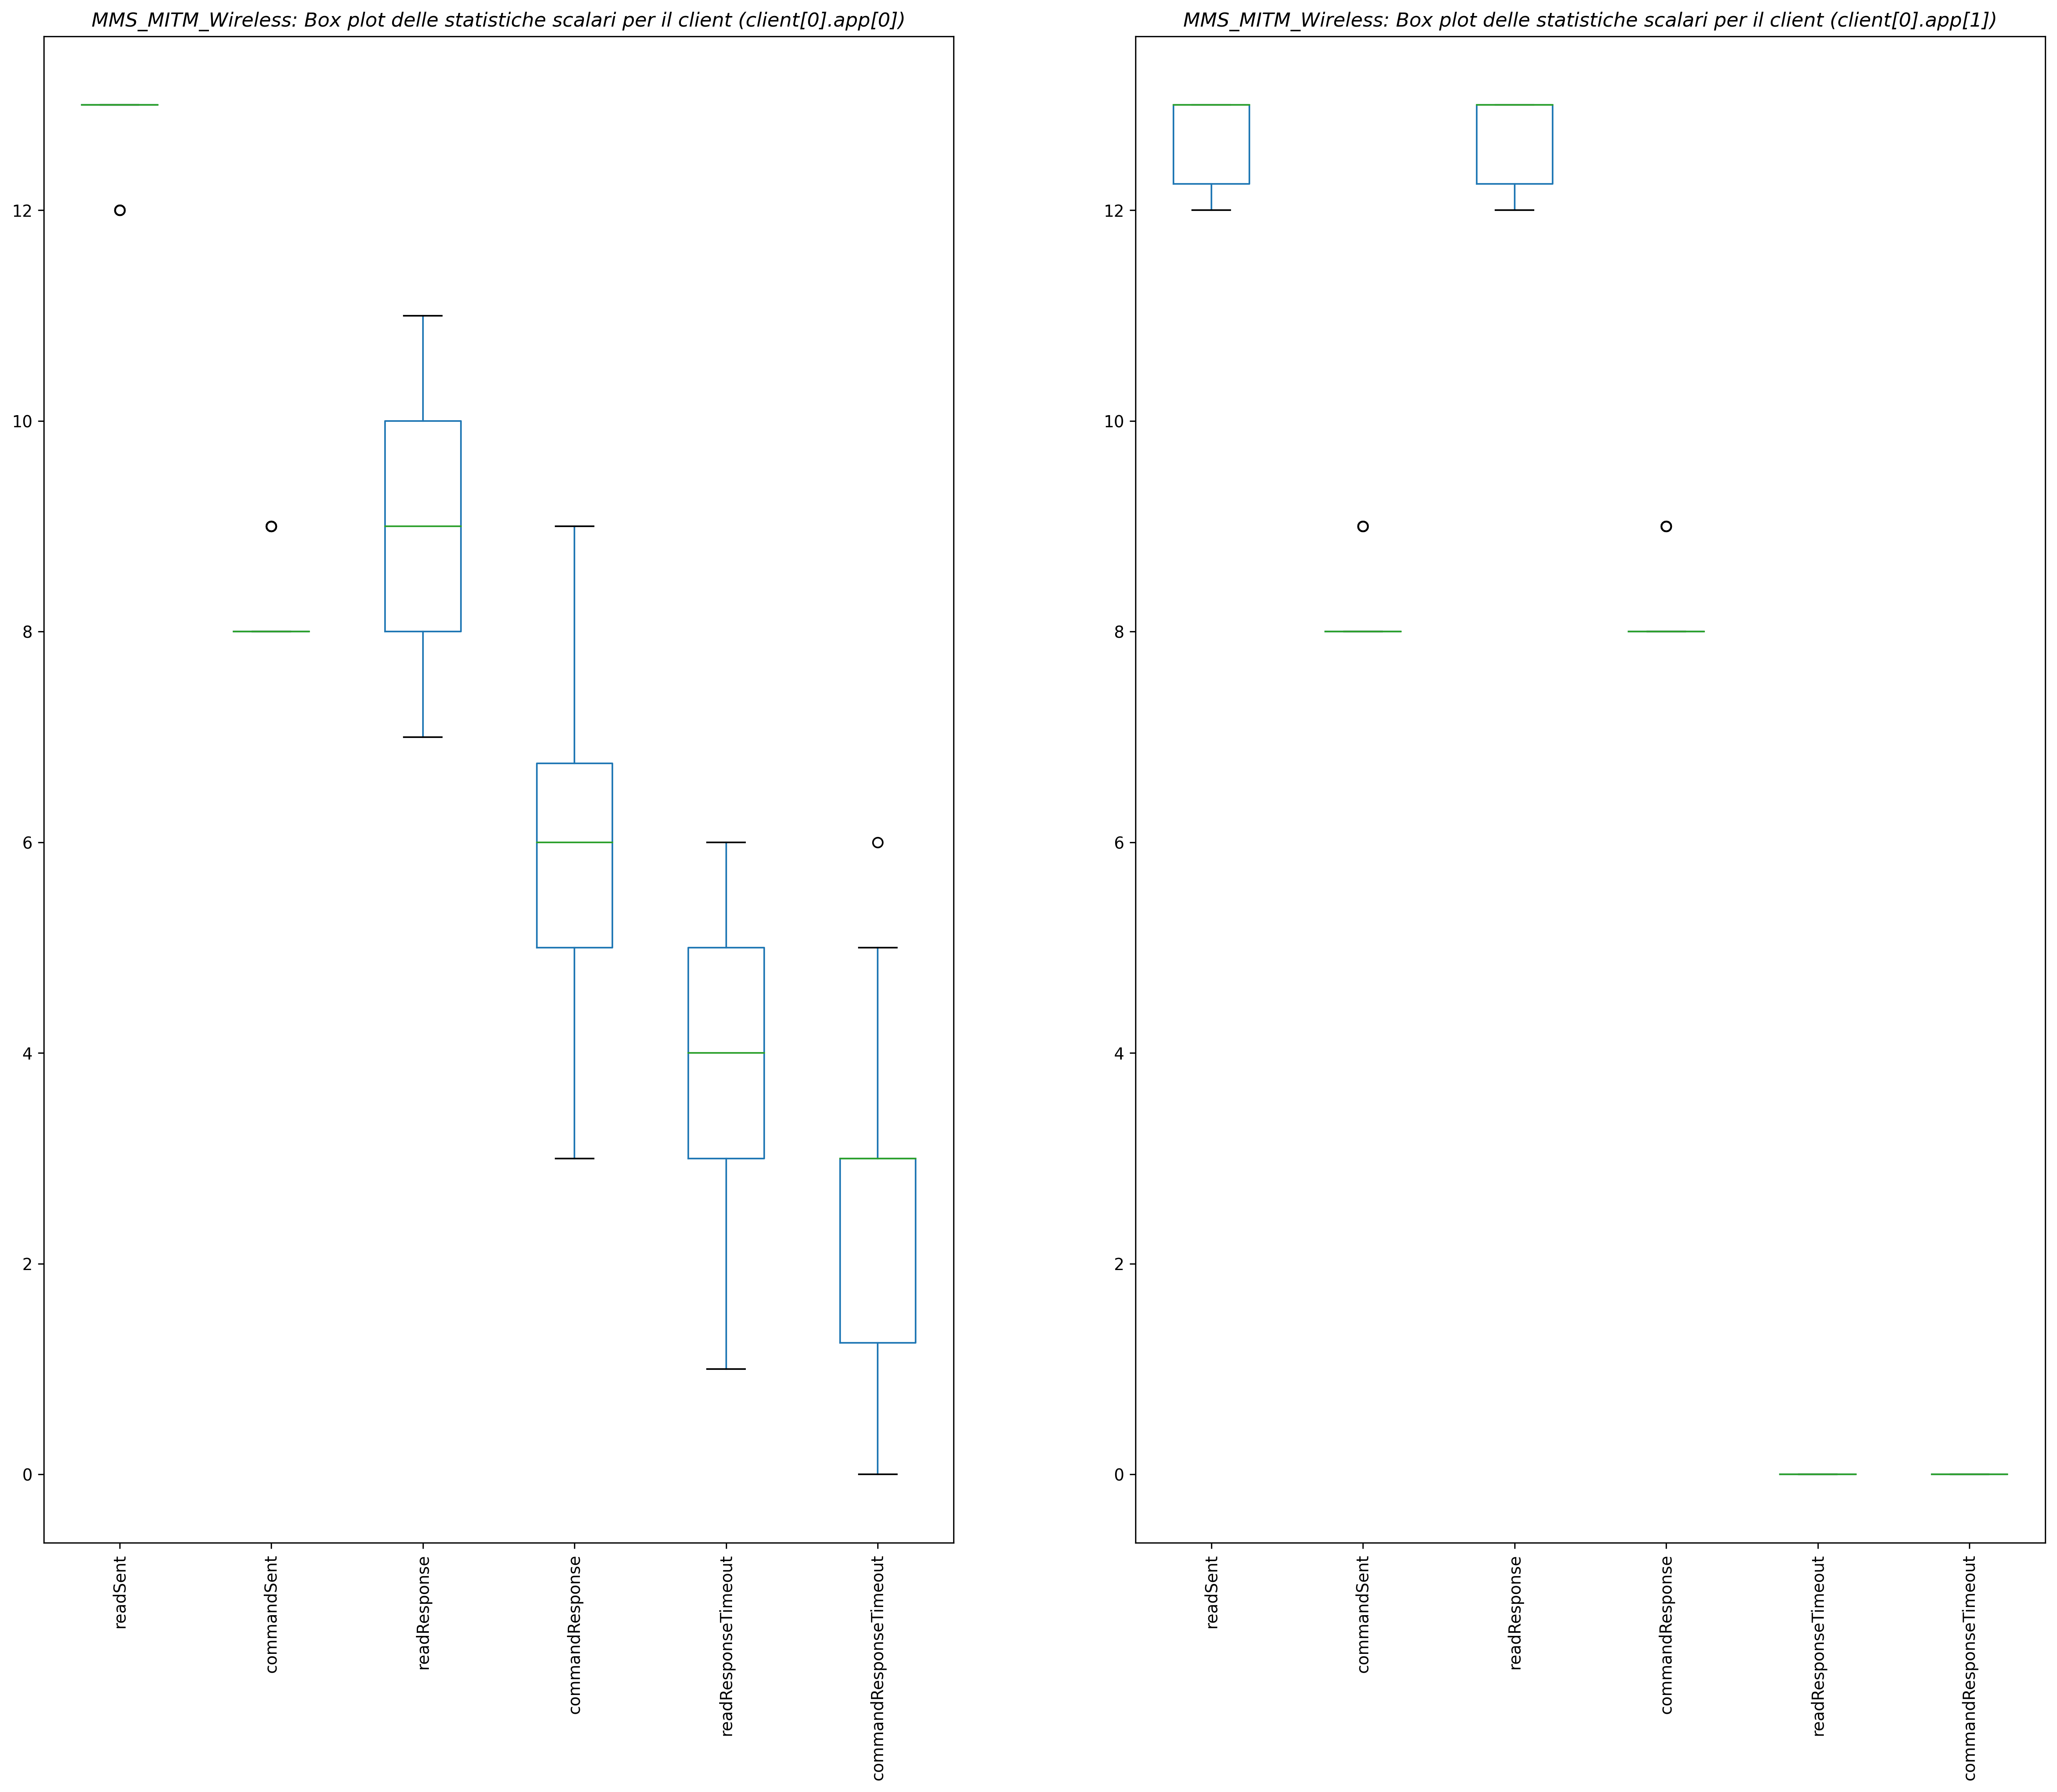

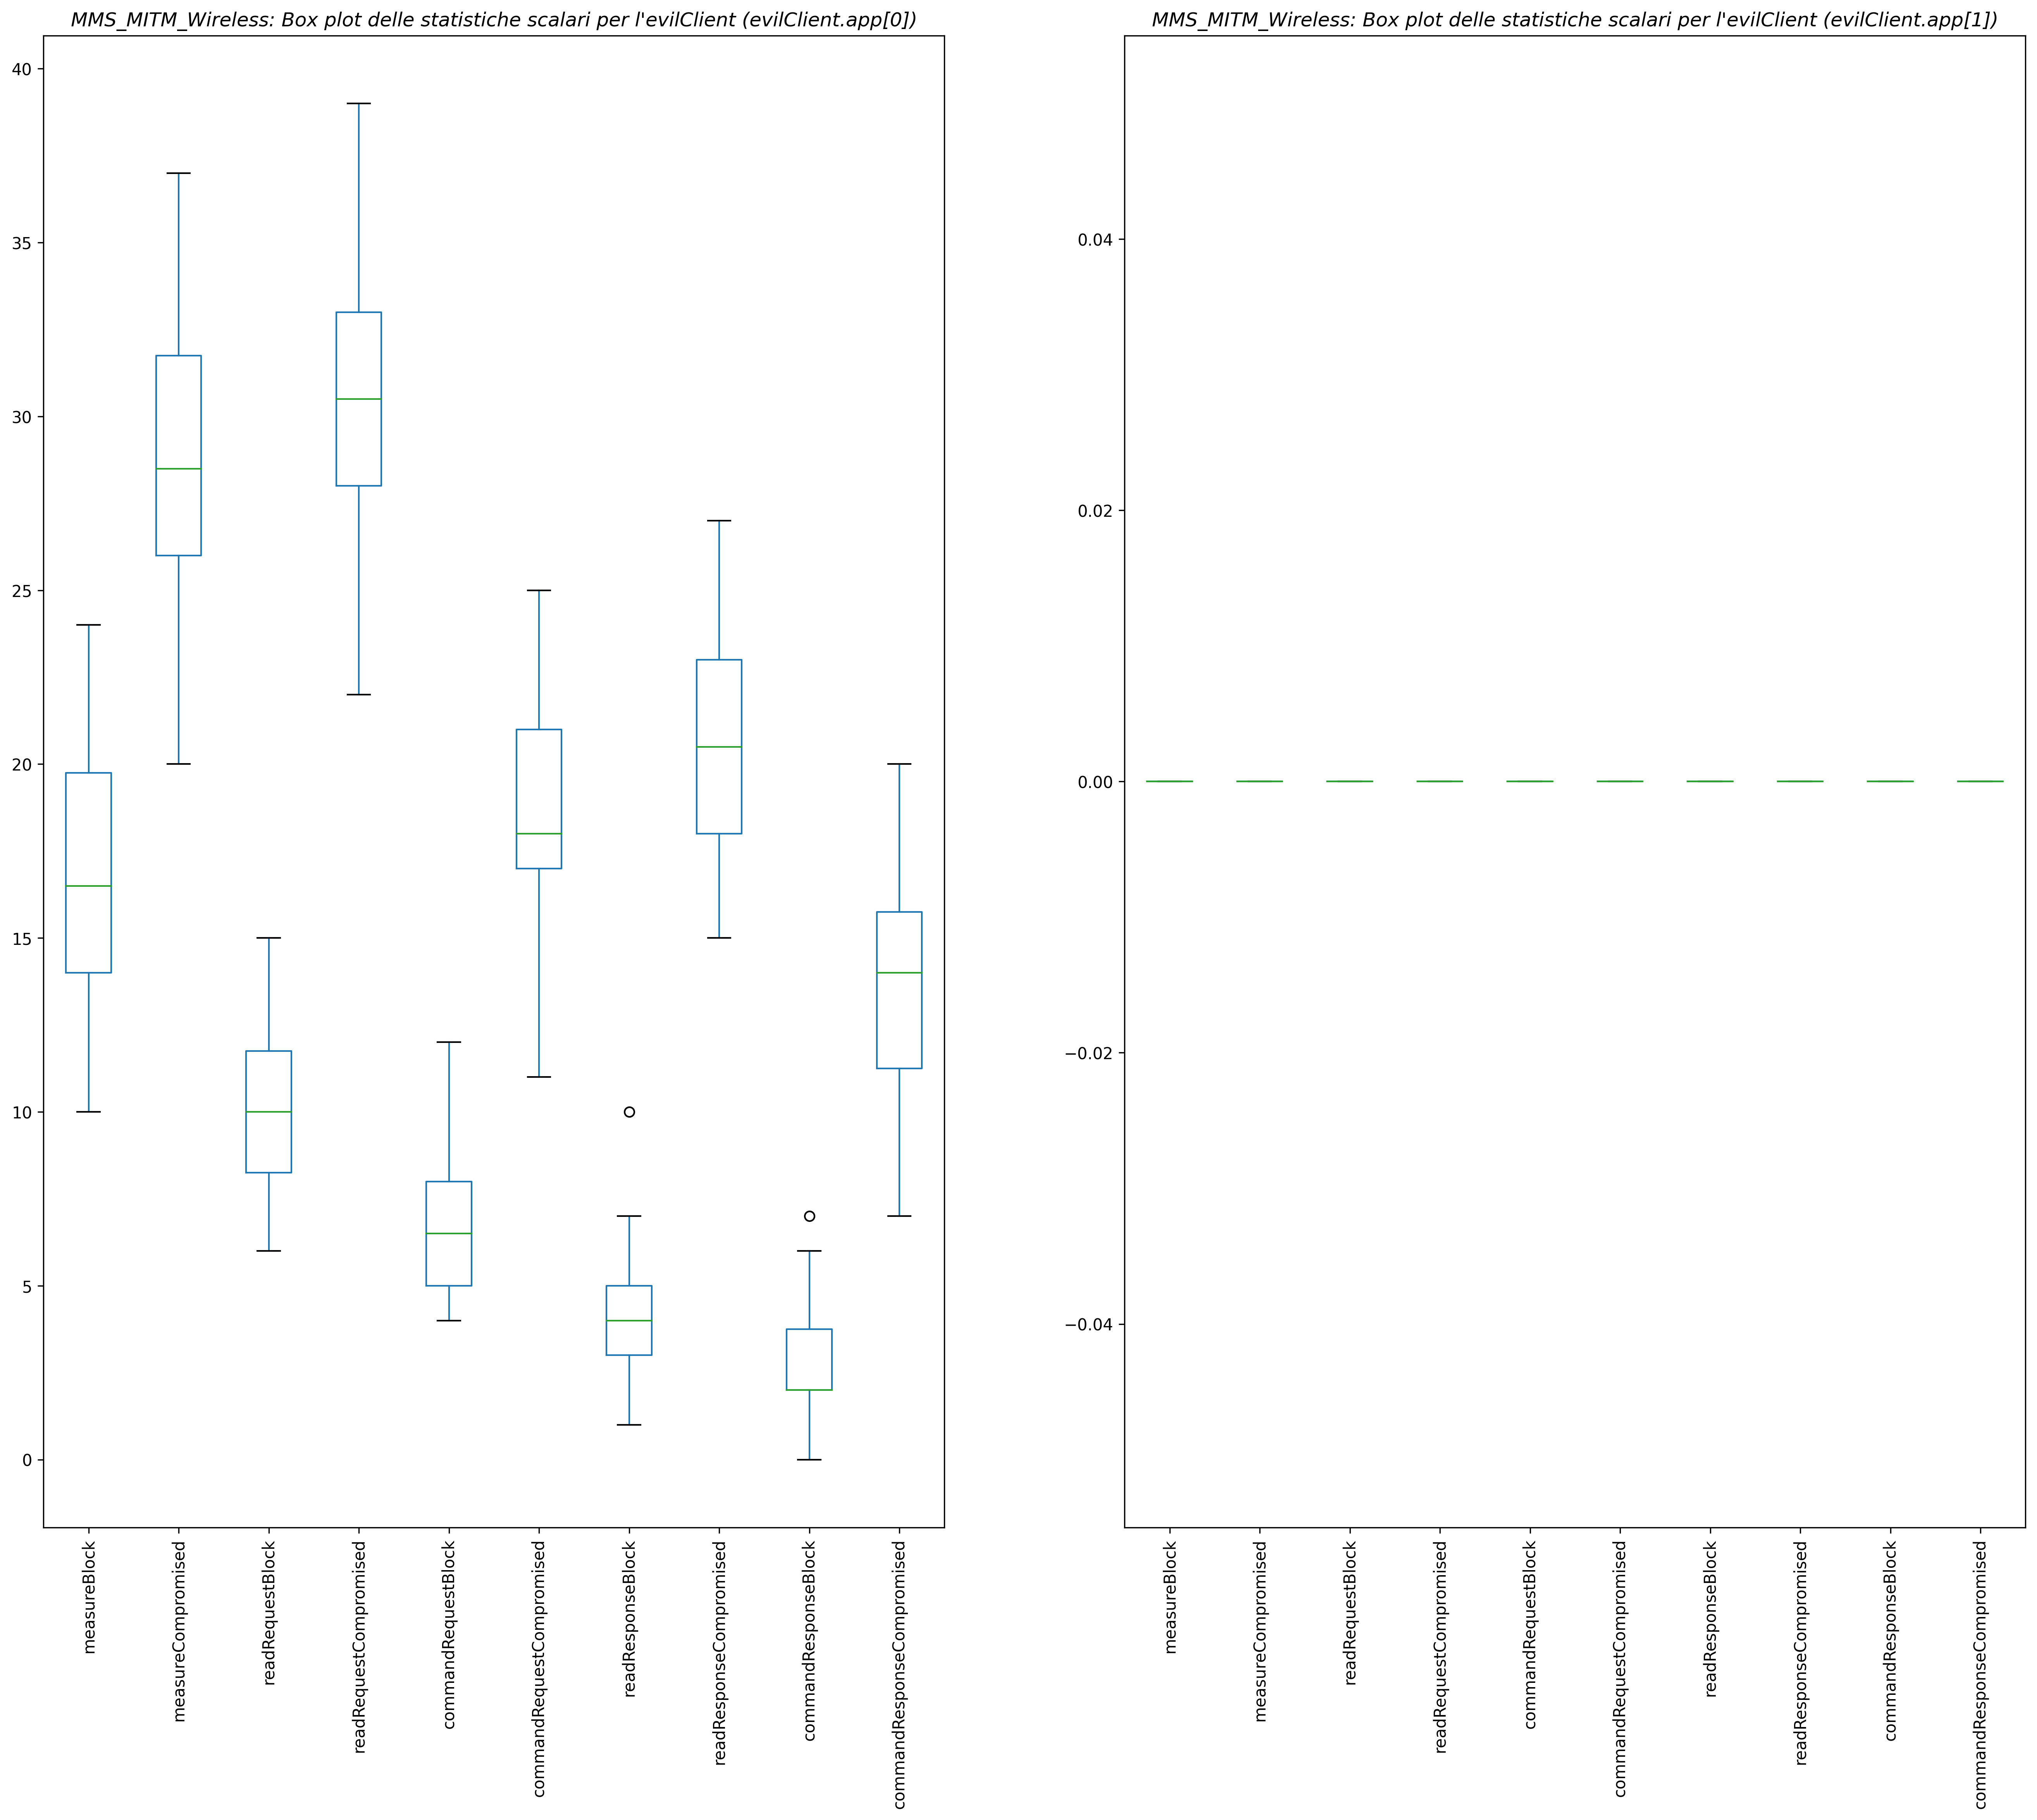

In [42]:
cliScaDfList = plotBoxWiskerSca(cliMeasNames, numClients, numServers, title=simName + ": Box plot delle statistiche scalari per il client")
evilScaDfList = plotBoxWiskerSca(evilMeasNames, 1, numServers, cli="evilClient", title=simName + ": Box plot delle statistiche scalari per l'evilClient")

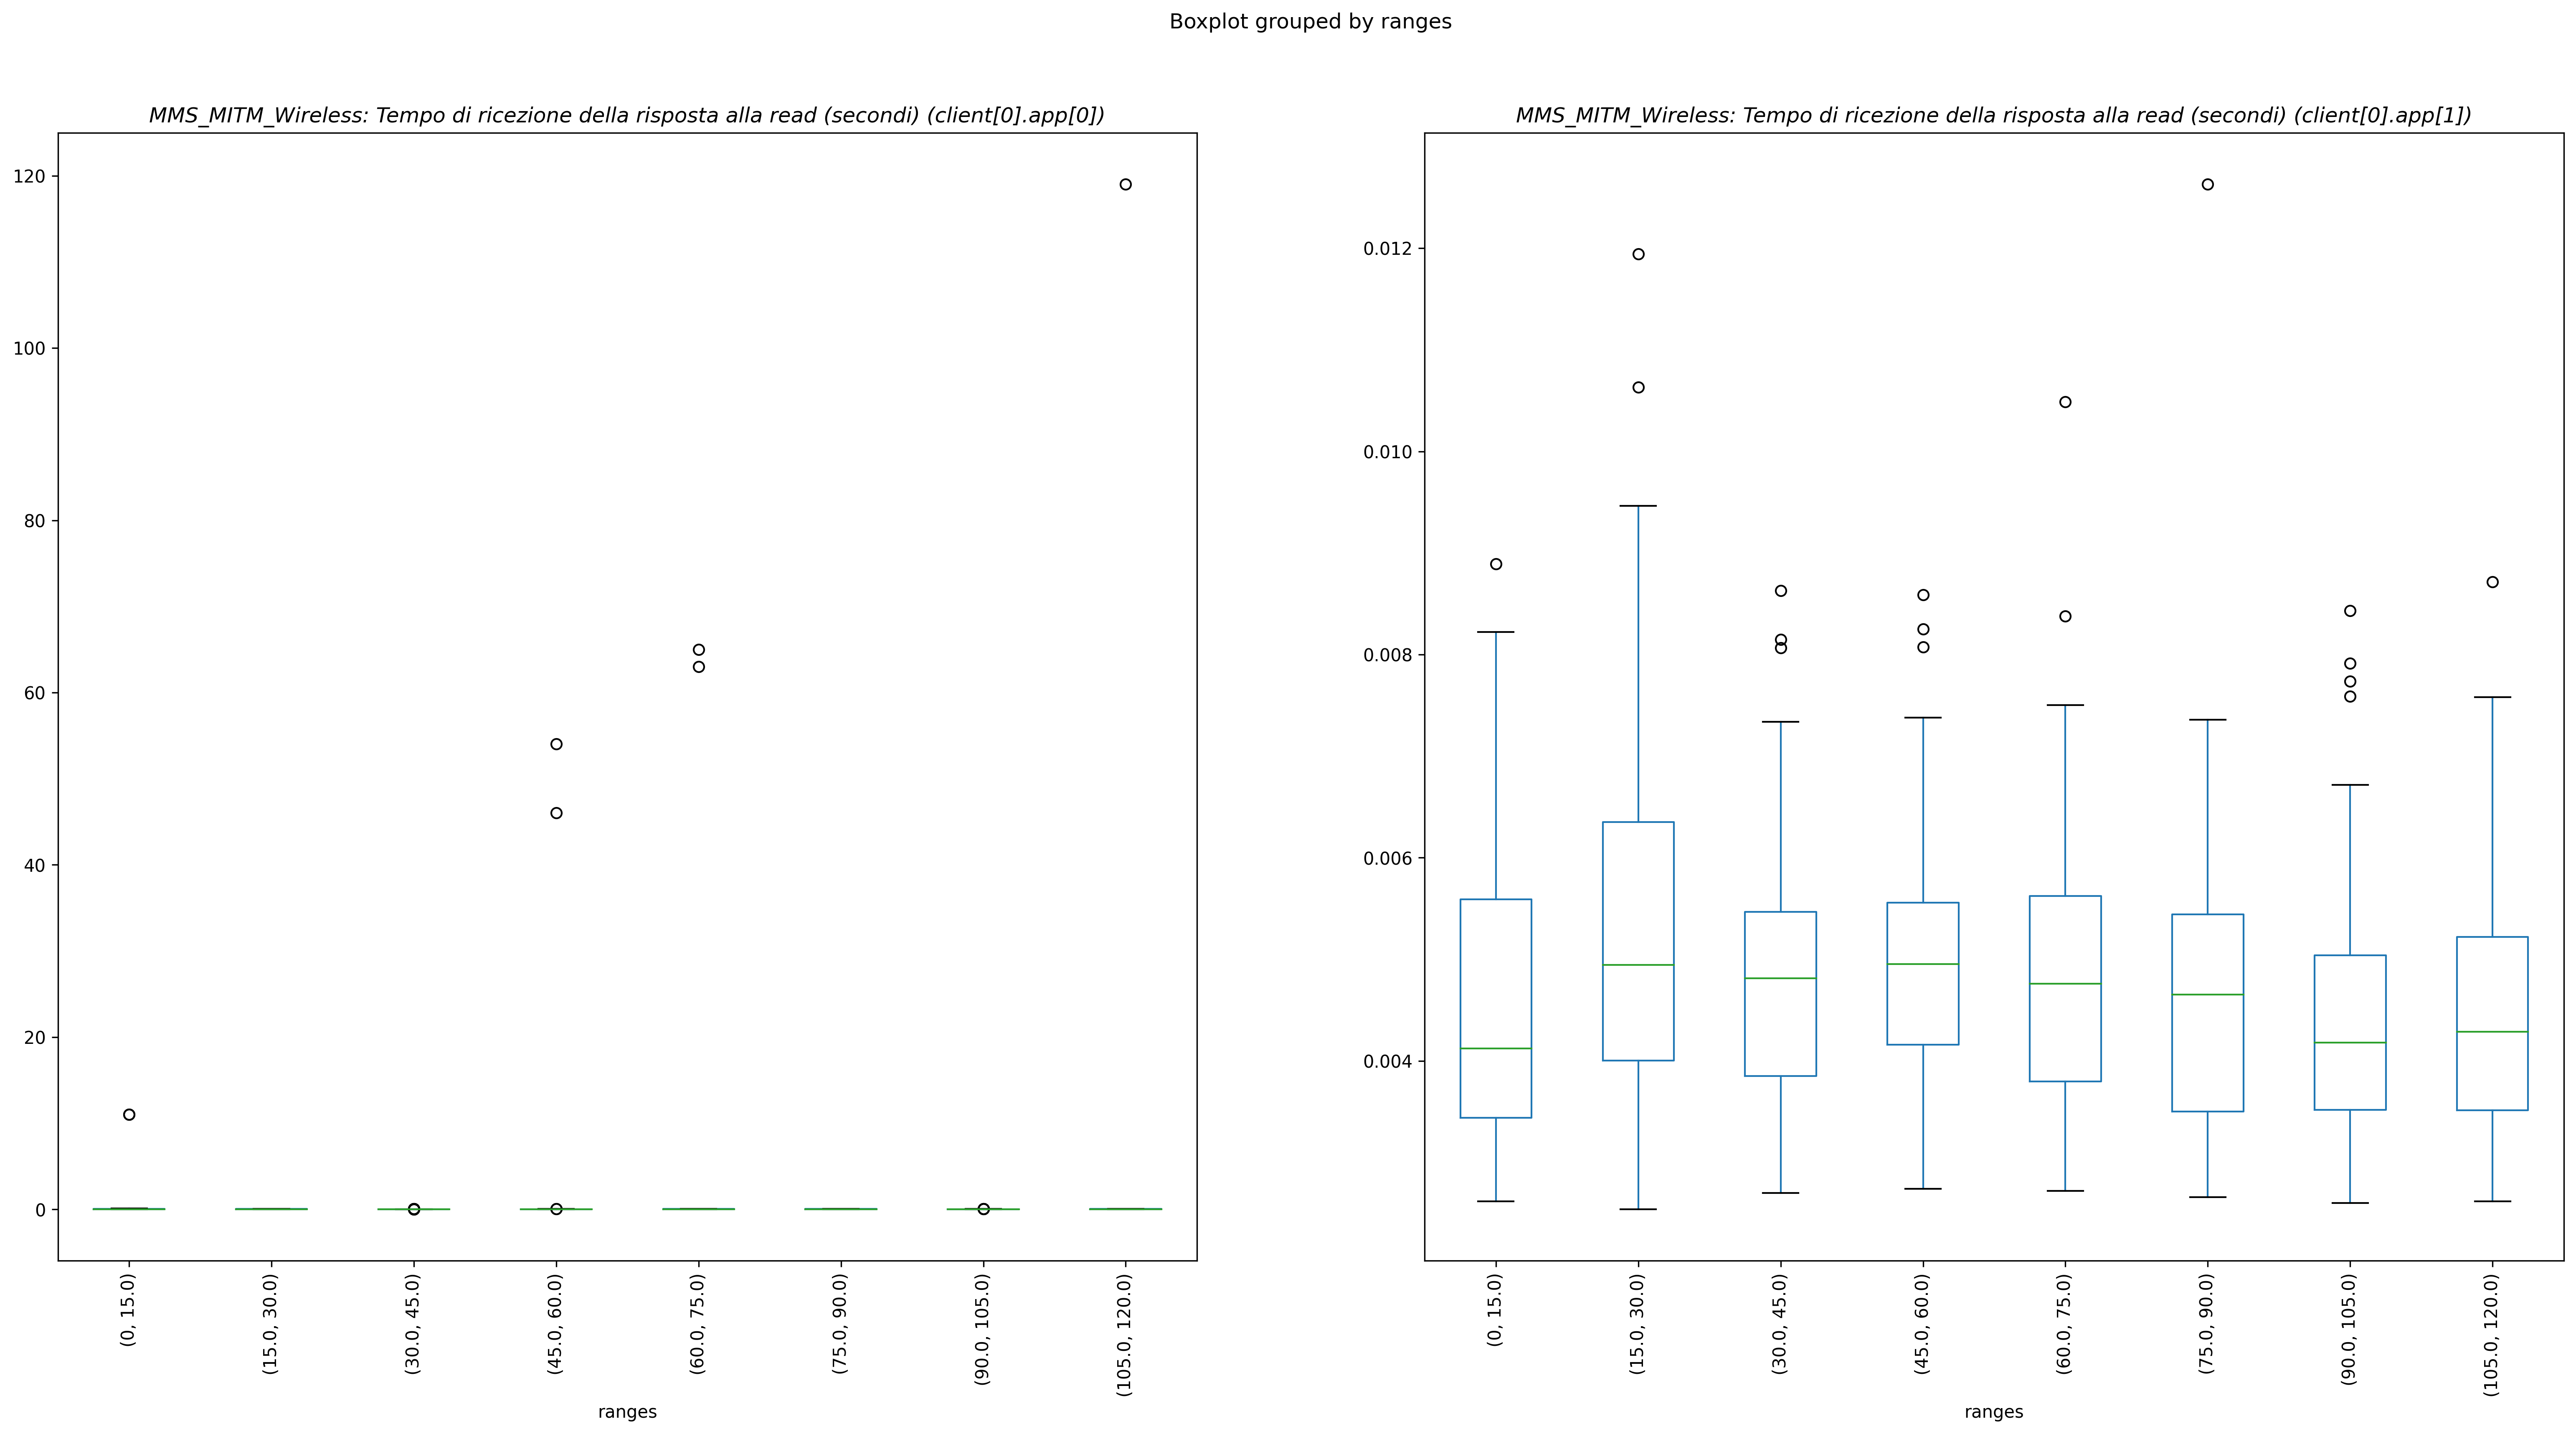

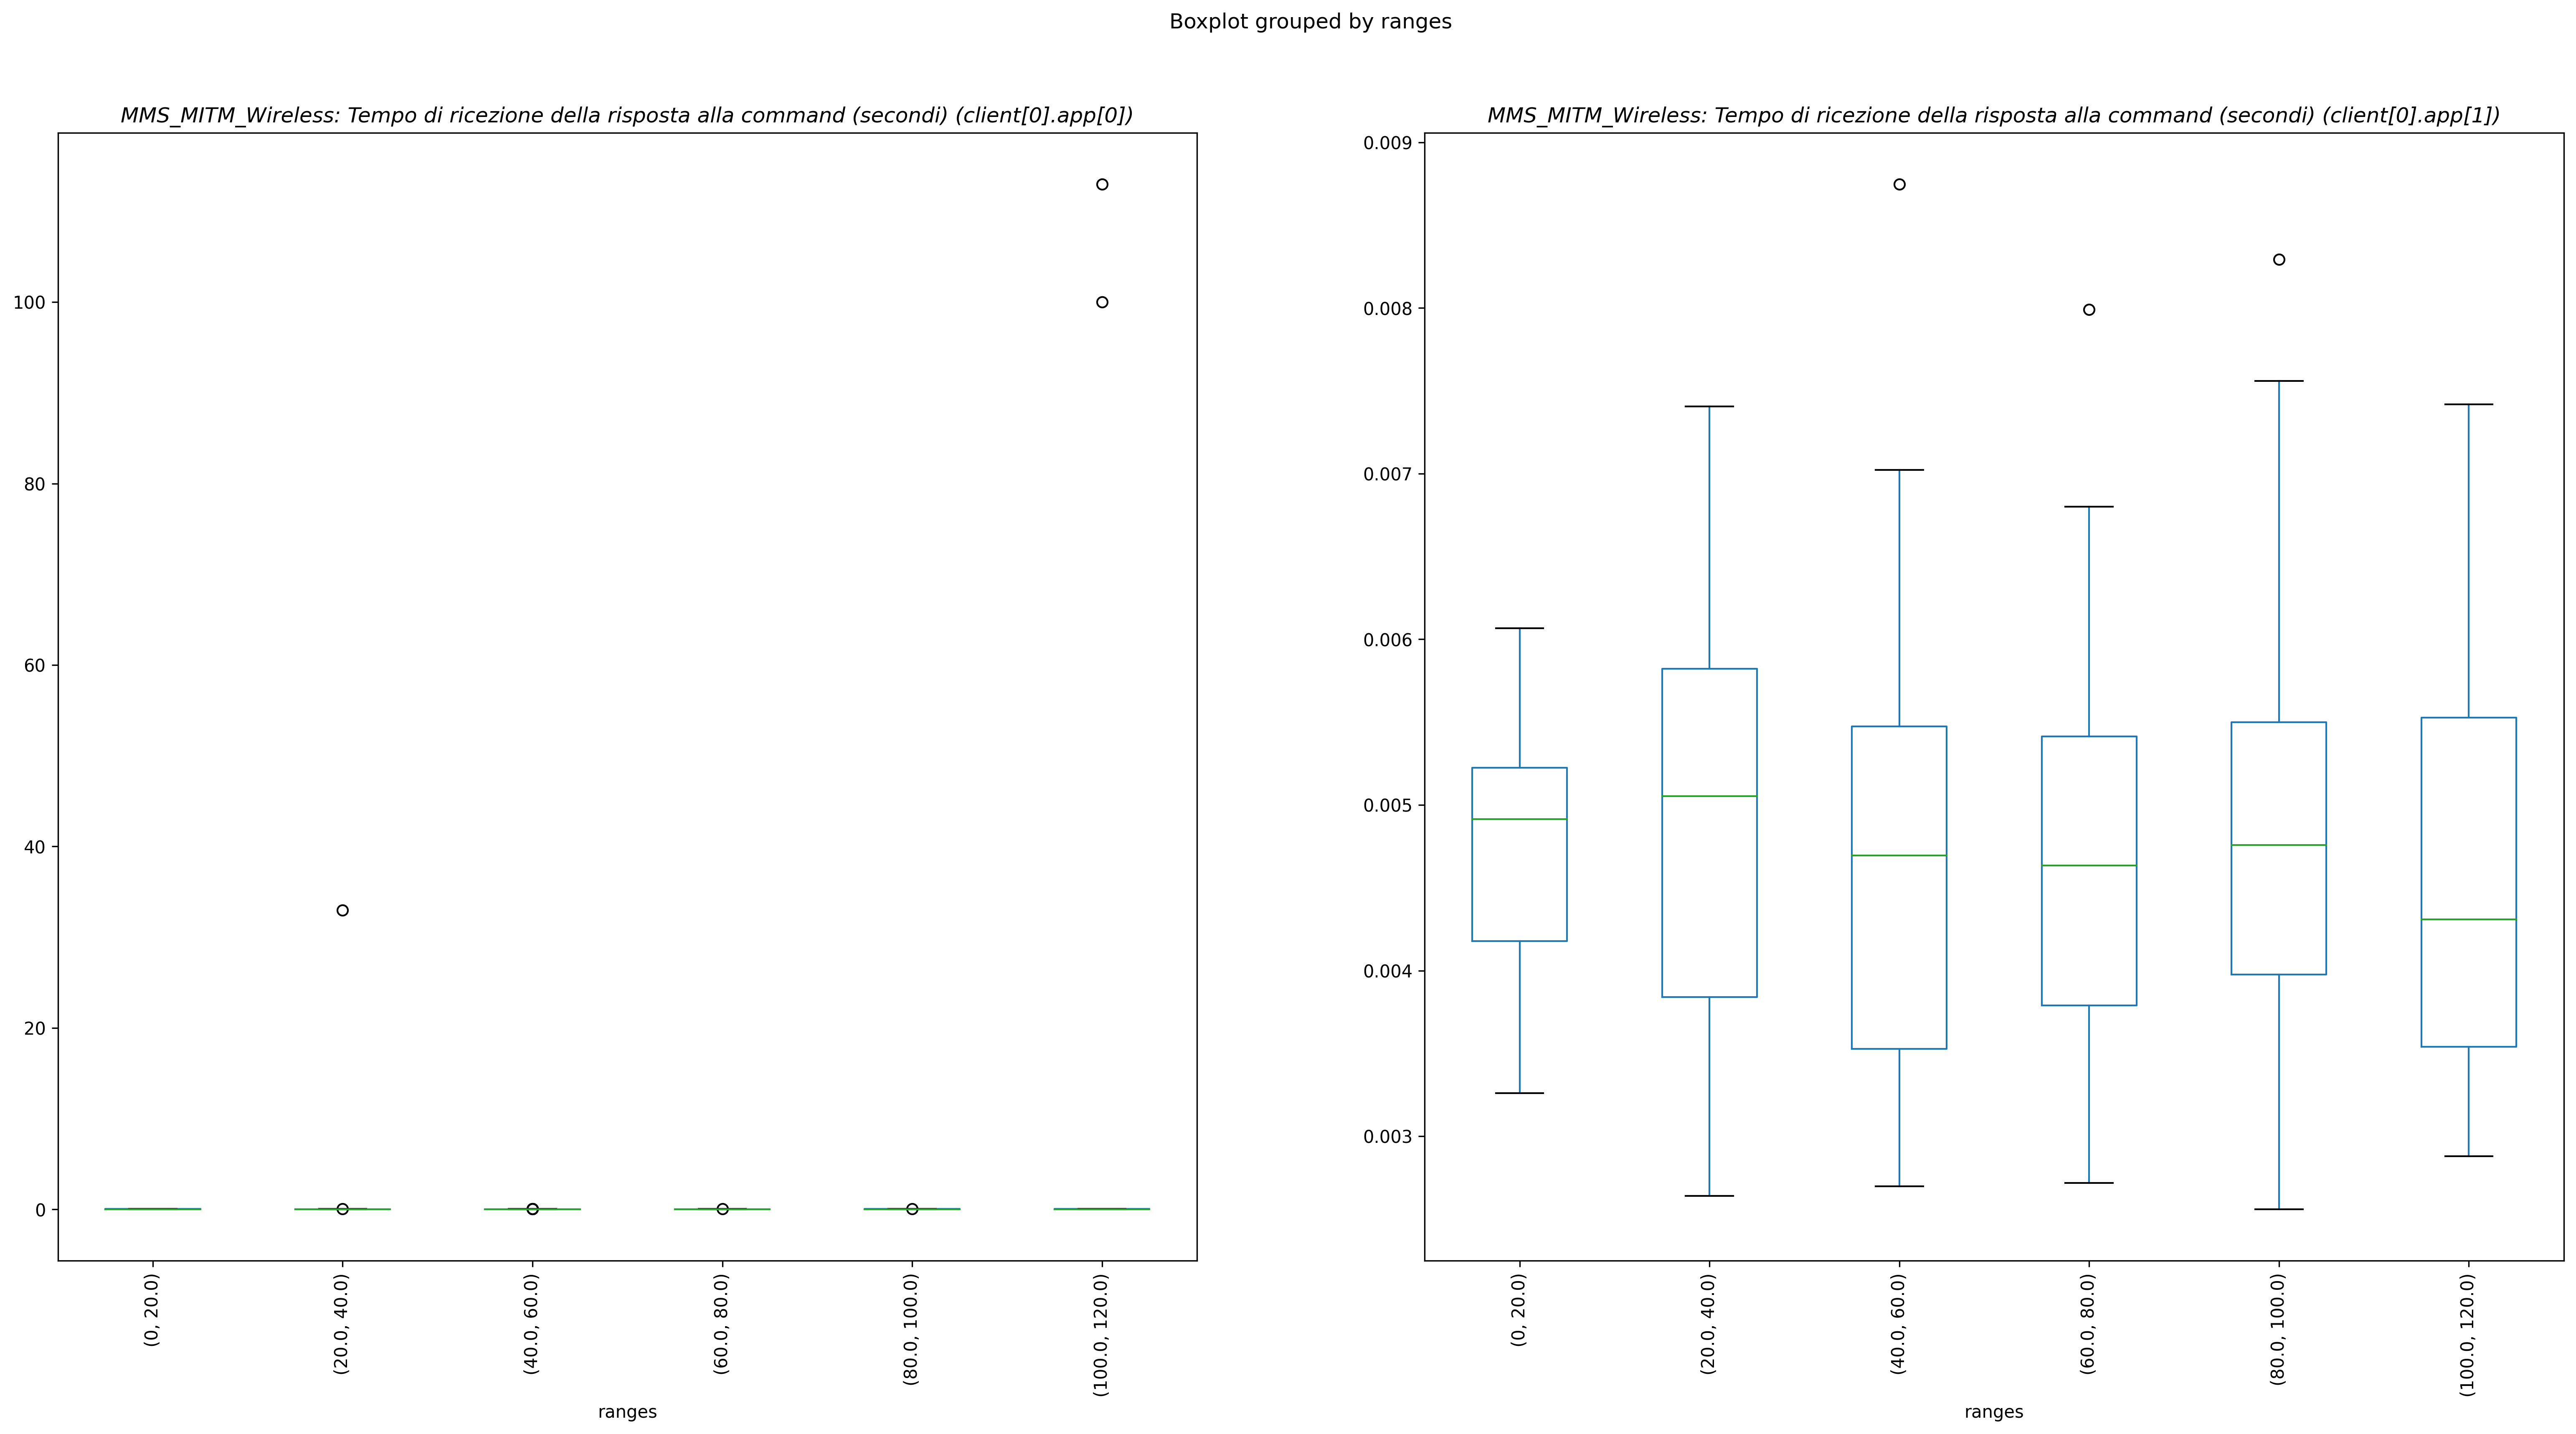

In [43]:
cliVecDfList = plotBoxWiskerVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla read (secondi)", vecMeasName="readResponseReceivedTime", numRanges = 8)
cliVecDfList = plotBoxWiskerVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla command (secondi)", vecMeasName="commandResponseReceivedTime", numRanges = 6)

In [44]:
def confidenceInterval(data, confidence = 0.95):
    for (colName, colData) in data.iteritems():
        a = 1.0 * np.array(colData.values)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        
        # m, m-h, m+h
        print("## Stat: " + colName)
        print("Average: " + str(m))
        print("Quantile: +-" + str(h)) 

Confidence interval for the different statistics

In [45]:
conf = 0.98
for i in range(numClients):
    for j in range(numServers):
        print("\n** " + simName + ": Confidence intervals for client[" + str(i) + "].app[" + str(j) + "] at " + str(conf*100) + "%  **")
        confidenceInterval(cliScaDfList[(i+1)*j], conf)


** MMS_MITM_Wireless: Confidence intervals for client[0].app[0] at 98.0%  **
## Stat: readSent
Average: 12.8
Quantile: +-0.18287435562890025
## Stat: commandSent
Average: 8.2
Quantile: +-0.18287435562890025
## Stat: readResponse
Average: 9.133333333333333
Quantile: +-0.5628319566615222
## Stat: commandResponse
Average: 5.766666666666667
Quantile: +-0.6538806069442901
## Stat: readResponseTimeout
Average: 3.8
Quantile: +-0.6508546017798569
## Stat: commandResponseTimeout
Average: 2.5
Quantile: +-0.6218400387226211

** MMS_MITM_Wireless: Confidence intervals for client[0].app[1] at 98.0%  **
## Stat: readSent
Average: 12.733333333333333
Quantile: +-0.20217520713302672
## Stat: commandSent
Average: 8.166666666666666
Quantile: +-0.17038312105320513
## Stat: readResponse
Average: 12.733333333333333
Quantile: +-0.20217520713302672
## Stat: commandResponse
Average: 8.166666666666666
Quantile: +-0.17038312105320513
## Stat: readResponseTimeout
Average: 0.0
Quantile: +-0.0
## Stat: commandResp

In [46]:
for j in range(numServers):
    print("\n** " + simName + ": Confidence intervals for evilClient.app[" + str(j) + "] at " + str(conf*100) + "%  **")
    confidenceInterval(evilScaDfList[j], conf)


** MMS_MITM_Wireless: Confidence intervals for evilClient.app[0] at 98.0%  **
## Stat: measureBlock
Average: 16.833333333333332
Quantile: +-1.7352331000529255
## Stat: measureCompromised
Average: 28.933333333333334
Quantile: +-1.758565124473453
## Stat: readRequestBlock
Average: 10.266666666666667
Quantile: +-1.1256639133230444
## Stat: readRequestCompromised
Average: 30.333333333333332
Quantile: +-1.6370972057288509
## Stat: commandRequestBlock
Average: 6.8
Quantile: +-0.8706560814264556
## Stat: commandRequestCompromised
Average: 19.0
Quantile: +-1.4838012461771266
## Stat: readResponseBlock
Average: 3.8333333333333335
Quantile: +-0.8681183042178159
## Stat: readResponseCompromised
Average: 20.766666666666666
Quantile: +-1.4681449958081738
## Stat: commandResponseBlock
Average: 2.7333333333333334
Quantile: +-0.7912824011983826
## Stat: commandResponseCompromised
Average: 13.566666666666666
Quantile: +-1.3597384384034916

** MMS_MITM_Wireless: Confidence intervals for evilClient.app[